# Analysing the Arenas resolution parameter
---

In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm

from utilities import import_networks
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [2]:
networks = import_networks()

print("\n".join([str(x) for x in networks]))

Graph with 1001 nodes and 75862 edges
Graph with 999 nodes and 75415 edges
Graph with 1025 nodes and 80306 edges
Graph with 1018 nodes and 80077 edges


## Finding Communities
---

In [221]:
# Adding self nodes
def add_self_loop(G,r: int):
    for node in G.nodes():
        G.add_edge(node,node,weight=r)

def get_communities(G,resolution):
    add_self_loop(G,resolution)
    comms = greedy_modularity_communities(G,resolution=1, weight="weight")
    return comms

In [381]:
# Calculate exoected r_min
for g in networks:
    add_self_loop(g,0)

total_degrees = [sum(dict(g.degree(weight="weight")).values()) for g in networks]
rmin = [int(-w/g.number_of_nodes()/2) for w,g in zip(total_degrees,networks)]

print(total_degrees)
print(rmin)

[1013542, 1013406, 1288802, 1320264]
[-1012, -1014, -1257, -1296]


In [39]:
#Dict for storing communities
communities_by_resolution =  dict(zip(range(2018,2022),[{},{},{},{}]))
print(communities_by_resolution)

{2018: {}, 2019: {}, 2020: {}, 2021: {}}


In [336]:
"""
Finding communities.
This can be run multiple times with different values of resolutions as needed
"""

%%time
# resolutions = np.unique(np.linspace(-620,100,200, dtype=int))
resolutions = np.arange(-390, 0, 5,dtype=int)
print(resolutions)
for resolution in tqdm(resolutions):
    for g,year in zip(networks,range(2018,2022)):
        communities_by_resolution[year][resolution] = [list(y) for y in get_communities(g,resolution=resolution)]

[-390 -385 -380 -375 -370 -365 -360 -355 -350 -345 -340 -335 -330 -325
 -320 -315 -310 -305 -300 -295 -290 -285 -280 -275 -270 -265 -260 -255
 -250 -245 -240 -235 -230 -225 -220 -215 -210 -205 -200 -195 -190 -185
 -180 -175 -170 -165 -160 -155 -150 -145 -140 -135 -130 -125 -120 -115
 -110 -105 -100  -95  -90  -85  -80  -75  -70  -65  -60  -55  -50  -45
  -40  -35  -30  -25  -20  -15  -10   -5]


  0%|          | 0/78 [00:00<?, ?it/s]

CPU times: user 41min 31s, sys: 274 ms, total: 41min 31s
Wall time: 41min 35s


In [297]:
#Classify Communities
communities_statistics = {}
for (year,comms),g in  zip(communities_by_resolution.items(),networks):
    communities_statistics[year] = {"N_communities":    [(r,len(x)) for r,x in comms.items()],
                                    "Avg_comm_size":    [np.average([len(y) for y in x]) for x in comms.values()],
                                    "Sigma_comm_size":  [np.std([len(y) for y in x]) for x in comms.values()],
                                    "Median_comm_size": [np.median([len(y) for y in x]) for x in comms.values()]}

In [282]:
# Export Data
import json
for year in range(2018,2022):
    keys = [float(x) for x in communities_by_resolution[year].keys()]
    communities_by_resolution[year] = dict(zip(keys, communities_by_resolution[year].values()))
with open("data/arenas_communities.json", "w") as f:
    json.dump(communities_by_resolution,f)

In [3]:
#Import data
import json
def keystoint(x):
    return {float(k): v for k, v in x.items()}
with open("data/arenas_communities.json", "r") as f:
    communities_by_resolution = json.load(f, object_hook=keystoint)

# Visualize data
---

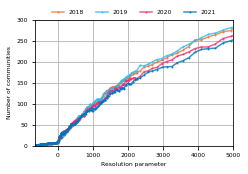

In [274]:
#Number of communities for small values of the parameters

colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)   
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    

cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.7*cm,0.7*8.7*cm))

ax.set(xscale="linear", yscale="linear",xlim=(-650,5000),ylim=(0,300),
      xlabel="Resolution parameter", ylabel="Number of communities")
for year, r in zip(range(2018,2022),rmin):
    n_comms = [len(y) for x,y in communities_by_resolution[year].items() if x > r]
    resolutions = [int(x) for x,y in communities_by_resolution[year].items() if x > r]
    
    resolutions,n_comms = list(zip(*sorted(list(zip(resolutions,n_comms)), key=lambda x: x[0])))

    ax.plot(resolutions,n_comms,marker="o",ls="-",markersize=1, label=year, c=colors[year],alpha=0.8)

ax.grid()
ax.legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
plt.tight_layout()
plt.savefig("images/arenas_community_N.pdf")

In [273]:
rminexp = {}
for g,year in zip(networks,range(2018,2022)):
    rminexp[year] = max([n for n,x in communities_by_resolution[year].items() if len(x)==1])
[x-y for x,y in zip(rminexp.values(), rmin)]

[48, 52, 48, 43]

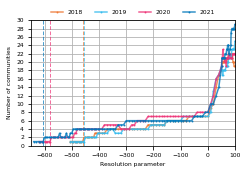

In [267]:
#Visualize statistics
colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    

cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.7*cm,0.7*8.7*cm))

ax.set(xscale="linear", yscale="linear",xlim=(-650,100),ylim=(0,30),
      xlabel="Resolution parameter", ylabel="Number of communities")
for year, r in zip(range(2018,2022),rmin):
    n_comms = [len(y) for x,y in communities_by_resolution[year].items() if x > r]
    resolutions = [int(x) for x,y in communities_by_resolution[year].items() if x > r]
    
    resolutions,n_comms = list(zip(*sorted(list(zip(resolutions,n_comms)), key=lambda x: x[0])))

    ax.plot(resolutions,n_comms,marker="o",ls="-",markersize=1, label=year, c=colors[year],alpha=0.8)
    ax.axvline(rminexp[year],c=colors[year],ls="--",lw=1,alpha=0.7)
    
ax.grid()
ax.set_yticks(range(0,32,2))
ax.legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
plt.tight_layout()
plt.savefig("images/arenas_community_N_negative.pdf")
# ax.legend()

{2018: 592672.0, 2019: 593102.0, 2020: 848585.0, 2021: 860300.0}


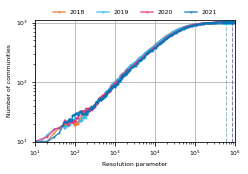

In [337]:
#Asymptotic behaviour

rmax = {}
for g,year in zip(networks,range(2018,2022)):
    rmax[year] = min([n for n,x in communities_by_resolution[year].items() if len(x)==g.number_of_nodes()])
pos = dict(zip(range(2018,2022),[2,5,105,250]))
print(rmax)

colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    

cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.7*cm,0.7*8.7*cm))

ax.set(xscale="log", yscale="log", xlim=(10,1e6),ylim=(10,1.1e3),
       xlabel="Resolution parameter", ylabel="Number of communities")
for year, r in zip(range(2018,2022),rmin):
    n_comms = [len(y) for x,y in communities_by_resolution[year].items() if x > r]
    resolutions = [int(x) for x,y in communities_by_resolution[year].items() if x > r]
    
    resolutions,n_comms = list(zip(*sorted(list(zip(resolutions,n_comms)), key=lambda x: x[0])))

    ax.plot(resolutions,n_comms,marker="o",ls="-",markersize=1, label=year, c=colors[year],alpha=0.8)
    ax.axvline(rmax[year],ls="--",lw=1,c=colors[year],alpha=0.5)
    # ax.text(rmax[year]-8e4,pos[year],year,ha="right")
    
ax.grid()
ax.legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
plt.tight_layout()
plt.savefig("images/arenas_asymptotic.pdf")
# ax.legend()

In [276]:
for year, g in zip(range(2018,2022),networks):
    x, y = communities_by_resolution[year][rmax[year]-1][0]
    wi  = nx.degree(g,x,weight="weight") 
    wj  = nx.degree(g,y,weight="weight") 
    wij = g.edges[x,y]['weight']
    print(x,wi,y,wj,wij)
    print()

0901_9813 5609 1507_9813 6428 1197

1504_9078 6804 0911_9078 4980 1200

0901_9813 8156 1507_9813 9938 1674

0901_9813 8219 1507_9813 10395 1709



In [161]:
ws = []
for g in networks[1:2]:
    for x in g.nodes():
        for y in g.nodes():
            if x != y:
                w = 506703/2
                n = 999
                try:
                    wij = g.edges[x,y]['weight']
                except:
                    continue
                wi  = nx.degree(g,x,weight="weight") 
                wj  = nx.degree(g,y,weight="weight") 
                r = 1.18569e6
                ws.append(((x,y), (2*w + n*r)*wij < (wi+r)*(wj+r),(wi,wj,wij)))
                
print([x for x  in ws if not x[1]])    
                

[(('0911_9078', '1504_9078'), False, (5880, 7704, 1200)), (('1504_9078', '0911_9078'), False, (7704, 5880, 1200))]


In [340]:
import json
def keystoint(x):
    return {float(k): v for k, v in x.items()}
with open("data/modularity_communities.json", "r") as f:
    communities_by_modularity = json.load(f, object_hook=keystoint)

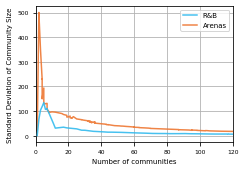

In [379]:
x_arenas = [len(y) for x,y in communities_by_resolution[2020].items() if len(y) <= 160]
y_arenas = [np.std([len(z) for z in y]) for x,y in communities_by_resolution[2020].items() if len(y) <= 160]

x_arenas, y_arenas = list(zip(*sorted(list(zip(x_arenas,y_arenas)), key=lambda x: x[0])))

x_modularity = [len(y) for x,y in communities_by_modularity[2020].items() if len(y) <= 160]
y_modularity = [np.std([len(z) for z in y]) for x,y in communities_by_modularity[2020].items() if len(y) <= 160]

x_modularity, y_modularity = list(zip(*sorted(list(zip(x_modularity,y_modularity)), key=lambda x: x[0])))


colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']


plt.rcParams.update({'font.size': 7})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    

cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.7*cm,0.7*8.7*cm))

ax.plot(x_modularity,y_modularity,label="R&B",marker="",ms=2,alpha=0.9,c=colors[1],zorder=3)
ax.plot(x_arenas,y_arenas,label="Arenas",marker="",ms=2,alpha=0.9,c=colors[0])


ax.set(xlabel="Number of communities", ylabel="Standard Deviation of Community Size",
      xlim=(0,120))
ax.grid()
ax.legend()
plt.tight_layout()
plt.savefig("images/std.pdf")

In [ ]:
sorted([x for x in communities_by_resolution[2018].keys() if x<50])

## Visualize Data
---

In [283]:
# Find matching communities NEW
def enumerate_simmilarity(enum, min_courses, max_courses):
    scores = []
    simmilarity = lambda x, y: len(set(x) & set(y))**2 /(1 + len(set(x) - set(y)) + len(set(y) - set(x)))
    for comm1 in min_courses:
        scores.append([simmilarity(comm1,comm2) for comm2 in max_courses])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(min_courses),-1)
        
    for i in range(len(min_courses)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1e6
        scores[:,index[1]] = -1e6
     
    return list(zip(best,enum))

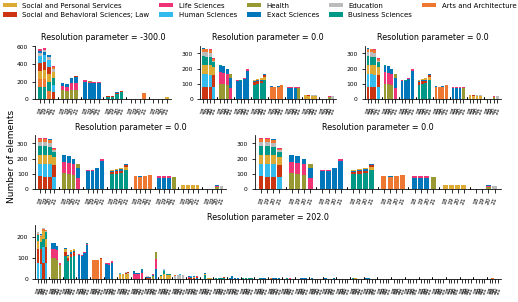

In [295]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
# fig,axes = plt.subplots(nrows=5, figsize=(17.8*cm,5*4*cm))

mosaic = """
EEEAAABBB
CCCCFFFFF
DDDDDDDDD
"""
fig = plt.figure(constrained_layout=False, figsize=(17.8*cm,3*3.5*cm))
ax_dict = fig.subplot_mosaic(mosaic)

# resolution_index = 9
for ax,resolution_index in zip(ax_dict.values(),[-300,0,0,0,0,202]):
    areas_in_comm = {}
    for G in networks:
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[G.graph["year"]][resolution_index]]
        areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]


    max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
    max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

    max_comms = communities_by_resolution[max_idx][resolution_index]
    
    for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
        if year == max_idx: 
            areas_in_comm[year] = max_comms_enum
            continue
        areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm.values())):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    years = list(range(18,22))*len(max_comms)
    idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
    idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        

    ax.set_xticks(idx_minor,minor=True)
    ax.set_xticks(idx,minor=False)
    ax.tick_params(which="minor",axis="x",direction="in")
    ax.set_xticklabels(years, rotation=70, fontdict={"fontsize":6})

    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.set_title(f"Resolution parameter = {resolution_index:.1f}", fontdict={"fontsize":8})

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = zip(*sorted(list(zip(handles,labels)),key=lambda x: x[1],reverse = True))
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.savefig("images/arenas_communities_by_field.pdf")
# plt.savefig("comm.jpeg",dpi=200)


In [289]:
sorted(list(communities_by_resolution[2018].keys()))

[-700.0,
 -690.0,
 -680.0,
 -670.0,
 -660.0,
 -650.0,
 -640.0,
 -630.0,
 -620.0,
 -615.0,
 -610.0,
 -605.0,
 -600.0,
 -595.0,
 -590.0,
 -585.0,
 -580.0,
 -575.0,
 -570.0,
 -565.0,
 -560.0,
 -555.0,
 -550.0,
 -545.0,
 -540.0,
 -535.0,
 -530.0,
 -525.0,
 -520.0,
 -515.0,
 -510.0,
 -505.0,
 -500.0,
 -495.0,
 -490.0,
 -485.0,
 -480.0,
 -475.0,
 -470.0,
 -465.0,
 -460.0,
 -458.0,
 -456.0,
 -455.0,
 -454.0,
 -452.0,
 -450.0,
 -445.0,
 -440.0,
 -435.0,
 -430.0,
 -425.0,
 -420.0,
 -415.0,
 -410.0,
 -405.0,
 -400.0,
 -390.0,
 -380.0,
 -370.0,
 -360.0,
 -350.0,
 -340.0,
 -330.0,
 -320.0,
 -310.0,
 -300.0,
 -290.0,
 -280.0,
 -270.0,
 -260.0,
 -250.0,
 -240.0,
 -230.0,
 -220.0,
 -210.0,
 -200.0,
 -190.0,
 -180.0,
 -170.0,
 -160.0,
 -150.0,
 -140.0,
 -130.0,
 -120.0,
 -110.0,
 -100.0,
 -90.0,
 -80.0,
 -70.0,
 -60.0,
 -50.0,
 -40.0,
 -30.0,
 -20.0,
 -10.0,
 0.0,
 10.0,
 20.0,
 30.0,
 40.0,
 50.0,
 52.0,
 53.0,
 55.0,
 56.0,
 58.0,
 60.0,
 61.0,
 63.0,
 67.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,

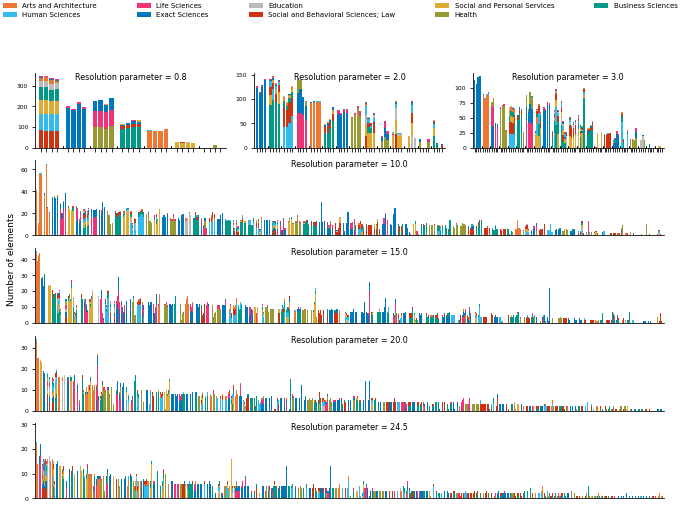

In [73]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))

plt.rcParams.update({'font.size': 9})

x0 = 0


mosaic = """
ABC
DDD
EEE
FFF
GGG
"""
cm = 1/2.54
fig = plt.figure(constrained_layout=False, figsize=(23.5*cm,17.8*cm))
ax_dict = fig.subplot_mosaic(mosaic)

for ax,resolution_index in zip(ax_dict.values(),[4,7,9,23,33,43,52]):
    areas_in_comm = []
    for n, G in enumerate(networks):
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
        areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])

    max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
    max_comms = max(areas_in_comm, key = len)
    max_comms_enum = list(enumerate(max_comms))

    for i in range(0,4):
        if i == max_idx: 
            areas_in_comm[i] = max_comms_enum
            continue
        areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    if resolution_index < 10:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks(idx_minor,minor=True)
        ax.set_xticks(idx,minor=False)
        ax.tick_params(which="minor",axis="x",direction="in")
        ax.set_xticklabels([""]*len(idx), rotation=65, fontdict={"fontsize":6})
    else:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks([],minor=False)
        ax.set_xticklabels([], rotation=65, fontdict={"fontsize":6})


    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.text(0.5,1,f"Resolution parameter = {resolutions[resolution_index]:.1f}", fontsize=8,transform=ax.transAxes,va="top",ha="center")

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.savefig("images/modularity_communities_by_field_extra.pdf",orientation='landscape')
# plt.savefig("comm.jpeg",dpi=200)


In [55]:
np,where(resolutions[resolutions==1]

array([1.])

**Dimensoes TeX: 17.8 x 23.5**

In [44]:
def simmilarity(x,y,z,w):
    return len(set(x) & set(y) & set(z) & set(w)) #/ (1 + sum([len(set(max([i,j],key=len)) - set(min([i,j],key=len))) for i in [x,y,z,w] for j in [x,y,z,w]])) 
    
# Find matching communities
def enumerate_simmilarity(enum, communities): #communities: list of 4 lists of communities
    max_n_communities = max([len(x) for x in communities])
        
    #Add fake empty communities so all years have the same
    for c in communities:
        c += [[]] * (max_n_communities - len(c))
        
    scores = np.full((max_n_communities,max_n_communities,max_n_communities,max_n_communities),-1)
    
    
    for i in range(max_n_communities):
        for j in range(max_n_communities):
            for k in range(max_n_communities):
                for l in range(max_n_communities):
                    scores[i,j,k,l] = simmilarity(communities[0][i],communities[1][j],communities[2][k],communities[3][l])
    print("Scores calculated")
    result = {}
    for n in range(max_n_communities):
        i,j,k,l = np.unravel_index(scores.argmax(),scores.shape)
        result[n] = [enum[2018][i],enum[2019][j],enum[2020][k],enum[2021][l]]
        scores[i,:,:,:] = -1e6
        scores[:,j,:,:] = -1e6
        scores[:,:,k,:] = -1e6
        scores[:,:,:,l] = -1e6
     
    return result

Scores calculated


IndexError: list index out of range

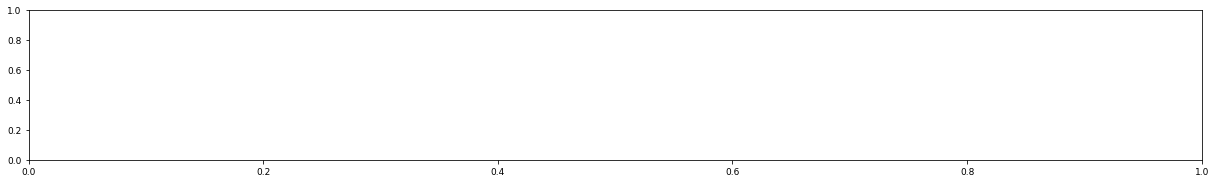

In [38]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(3*17.8*cm,7*cm))

resolution_index = 7
areas_in_comm = {}
for G in networks:
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]
    
max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

max_comms = communities_by_resolution[str(max_idx)][resolution_index]

areas_in_comm = enumerate_simmilarity(areas_in_comm, [comm[resolution_index] for comm in communities_by_resolution.values()])
print(areas_in_comm[1])
# for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
#     if year == max_idx: 
#         areas_in_comm[year] = max_comms_enum
#         continue
#     areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)
    
for n, areas_year in enumerate(areas_in_comm.values()):
    y_offset = 0
    for i,area in enumerate(areas_year):
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + n*5+i,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)


# Cities

TypeError: enumerate_simmilarity() missing 1 required positional argument: 'max_courses'

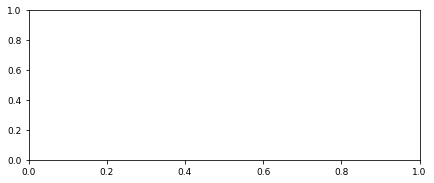

In [54]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
# areas  = ['Educação', 'Artes e Arquitetura',
          # 'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          # 'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
# areas_en  = ['Education', 'Arts and Architecture',
          # 'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          # 'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
# areas_en=dict(zip(areas,areas_en))
# area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(17.8*cm,7*cm))

resolution_index = 5
areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["faculty_name"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset)
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)
